In [47]:
pip install lifetimes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [48]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
df = pd.read_excel('C:/netision/powerbi/CA/Dataset/customer_shopping_data.xlsx')
df.head()

,invoice_no,customer_id,gender,age,Customer Name,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C332132,Male,18,Customer_C332132,Clothing,5,1500.40,Credit Card,2022-05-08 00:00:00,Kanyon
1,I317333,C238894,Female,63,Customer_C238894,Shoes,3,1800.51,Debit Card,2021-12-12 00:00:00,Forum Istanbul
2,I127801,C302185,Male,56,Customer_C302185,Clothing,1,300.08,Cash,2021-09-11 00:00:00,Metrocity
3,I173702,C272390,Male,63,Customer_C272390,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C155836,Male,59,Customer_C155836,Books,4,60.60,Cash,24/10/2021,Kanyon


In [50]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [61]:
# Define a snapshot date for recency calculation (e.g., the day after the last transaction)
snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)

# Group by CustomerID to calculate RFM metrics
rfm_table = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days, # Recency: Days since last purchase
    'customer_id': 'count',                                      # Frequency: Total number of purchases
    'price': 'sum'                             # Monetary: Total amount spent
   
})

# Rename the columns for clarity
rfm_table.rename(columns={
    'invoice_date': 'Recency', 
    'customer_id': 'Frequency', 
    'price': 'Monetary'
}, inplace=True)

# Display the first few rows of the RFM table
print(rfm_table.head(20))


             Recency  Frequency  Monetary
customer_id                              
C100004          348          3   2876.66
C100006          592          3   1048.42
C100019          907          1    600.16
C100041          880          1     11.73
C100045          512          1   1500.40
C100066          990          2   1236.16
C100090          872          1    162.64
C100095          830          1    900.24
C100099          824          1    600.16
C100105          314          2   1800.48
C100106          304          5   1552.70
C100110          357          3   1881.83
C100112          279          1     11.73
C100132          488          4   3514.97
C100152          338          3   1484.94
C100155          682          2   1800.48
C100156          124          5   1911.79
C100157          313          4   1252.62
C100159          477          3    283.94
C100168          357          4   2248.70


In [62]:
rfm_table['R_rank'] = rfm_table['Recency'].rank(ascending=False)
rfm_table['F_rank'] = rfm_table['Frequency'].rank(ascending=True)
rfm_table['M_rank'] = rfm_table['Monetary'].rank(ascending=True)

In [63]:
rfm_table['R_rank_norm'] = (rfm_table['R_rank'] / rfm_table['R_rank'].max()) * 100
rfm_table['F_rank_norm'] = (rfm_table['F_rank'] / rfm_table['F_rank'].max()) * 100
rfm_table['M_rank_norm'] = (rfm_table['M_rank'] / rfm_table['M_rank'].max()) * 100

In [64]:
rfm_table.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
customer_id,,,,,,
C100004,348,3,2876.66,78.504662,70.400638,80.415387
C100006,592,3,1048.42,34.447270,70.400638,45.053072
C100019,907,1,600.16,7.462162,14.648565,32.630141
C100041,880,1,11.73,9.060419,14.648565,1.966924
C100045,512,1,1500.40,45.989829,14.648565,57.942649


In [65]:
rfm_table['RFM_Score'] = 0.15 * rfm_table['R_rank_norm'] + 0.28 * rfm_table['F_rank_norm'] + 0.57 * rfm_table['M_rank_norm']
rfm_table['RFM_Score'] *= 0.05
rfm_table = rfm_table.round(2)

In [66]:
rfm_table[ 'RFM_Score'].head(7)

customer_id
C100004    3.87
C100006    2.53
C100019    1.19
C100041    0.33
C100045    2.20
C100066    2.13
C100090    0.80
Name: RFM_Score, dtype: float64

In [67]:
rfm_table["Customer_segment"] = np.where(rfm_table['RFM_Score'] > 4.5, "Top Customers",
                                       np.where(rfm_table['RFM_Score'] > 4, "High value Customer",
                                                np.where(rfm_table['RFM_Score'] > 3, "Medium Value Customer",
                                                         np.where(rfm_table['RFM_Score'] > 1.6, 'Low Value Customers', 'Lost Customers'))))

In [68]:
rfm_table[[ 'RFM_Score', 'Customer_segment']].head(20)

,RFM_Score,Customer_segment
customer_id,,
C100004,3.87,Medium Value Customer
C100006,2.53,Low Value Customers
C100019,1.19,Lost Customers
C100041,0.33,Lost Customers
C100045,2.20,Low Value Customers
C100066,2.13,Low Value Customers
C100090,0.80,Lost Customers
C100095,1.45,Lost Customers
C100099,1.23,Lost Customers


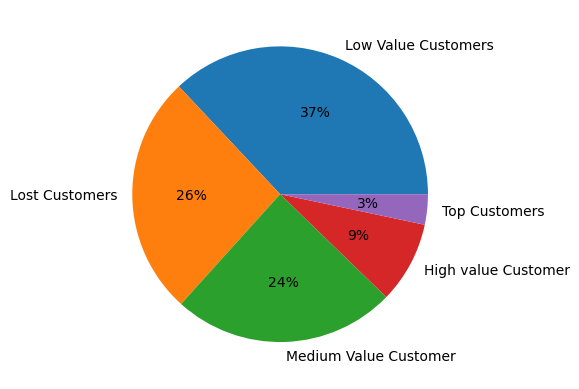

In [69]:
plt.pie(rfm_table.Customer_segment.value_counts(),
        labels=rfm_table.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [70]:
rfm_table.to_csv("C:/netision/powerbi/CA/Dataset.csv", index=False)


In [71]:
import lifetimes
current_date = df['invoice_date'].max()

# calculate the required customer metrics
metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    df,
    customer_id_col='customer_id',
    datetime_col='invoice_date',
    observation_period_end = current_date, 
    freq='D'
    )
  )

metrics_pd.head(10)


,frequency,recency,T
customer_id,,,
C100004,2.0,526.0,873.0
C100006,2.0,253.0,844.0
C100019,0.0,0.0,906.0
C100041,0.0,0.0,879.0
C100045,0.0,0.0,511.0
C100066,1.0,72.0,1061.0
C100090,0.0,0.0,871.0
C100095,0.0,0.0,829.0
C100099,0.0,0.0,823.0


In [72]:
rf_df = rfm_table.merge(metrics_pd, on='customer_id').drop(columns= ['recency','frequency'])
rf_df.head()

,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,T
customer_id,,,,,,,,,
C100004,348,3,2876.66,78.50,70.40,80.42,3.87,Medium Value Customer,873.0
C100006,592,3,1048.42,34.45,70.40,45.05,2.53,Low Value Customers,844.0
C100019,907,1,600.16,7.46,14.65,32.63,1.19,Lost Customers,906.0
C100041,880,1,11.73,9.06,14.65,1.97,0.33,Lost Customers,879.0
C100045,512,1,1500.40,45.99,14.65,57.94,2.20,Low Value Customers,511.0


In [73]:
reference_date= df['invoice_date'].max()

In [74]:
from lifetimes import BetaGeoFitter
import pandas as pd

data = rf_df.copy()

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['Frequency'], data['Recency'], data['T'])

# Predict purchases in next 30 days
data['predicted_purchases'] = bgf.predict(
    30,  # days to predict
    data['Frequency'],
    data['Recency'],
    data['T']
)

print(data)

ValueError: Some values in recency vector are larger than T vector.